In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier

In [31]:
with np.load('cifar4-train.npz', allow_pickle = False) as data :
    X = data['pixels'].astype(np.float32)
    O = data['overfeat']
    y = data['labels']
    names = data['names']

# Data Visualization

In [3]:
pd.value_counts(y, normalize = True, ascending = True)

0    0.25
1    0.25
2    0.25
3    0.25
dtype: float64

We see that every type is equally represented (as it should). Hence the 'most-frequent'-baseline accuracy is 25 %. Let us take a look at some of the images :

trucks :


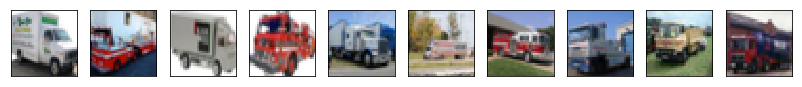

cars :


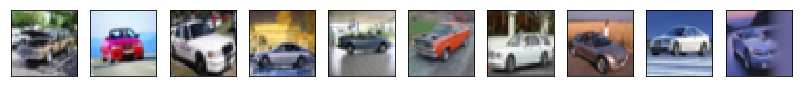

planes :


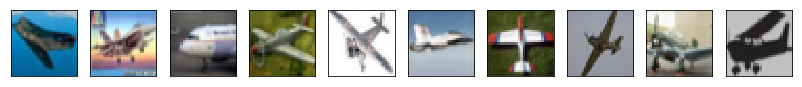

ships :


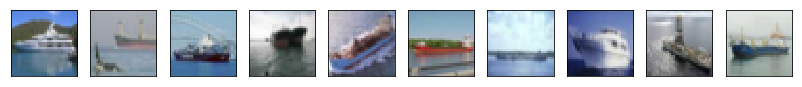

In [32]:
def visualize_images(type, labels):
    print(type, ':' )
    fig, ax = plt.subplots(1, 10, figsize = (14, 2))
    for i in range(len(labels)):
        img = X[labels[i]].reshape(32, 32, 3)
        ax[i].imshow(img / 255)
        ax[i].get_xaxis().set_visible(False) 
        ax[i].get_yaxis().set_visible(False)  
    plt.show()
    
visualize_images('trucks', [0, 5, 6, 8, 9, 14, 29, 33, 34, 37] )
visualize_images('cars', [1, 3, 4, 11, 12, 17, 24, 25, 28, 38])
visualize_images('planes', [2, 7, 13, 16, 18, 19, 20, 30, 35, 53])
visualize_images('ships', [10, 15, 21, 22, 23, 26, 27, 31, 32, 36])

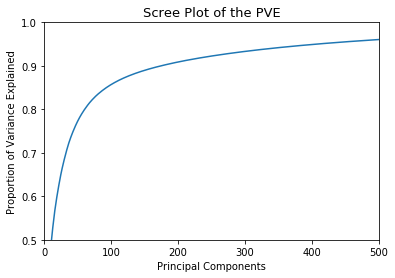

In [5]:
scaler = StandardScaler()
pca = PCA(n_components = None)
O_resc = scaler.fit_transform(O)
pca.fit(O_resc)
pve = pca.explained_variance_ratio_

plt.plot(np.cumsum(pve))
plt.ylim(0.5, 1)
plt.xlim(0, 500)
plt.xlabel('Principal Components')
plt.ylabel('Proportion of Variance Explained')
plt.title('Scree Plot of the PVE', fontsize = 13)
plt.show()

We see that the function is asymptotic to 1. It is already possible to have already a good amount of information if we project our model onto 100 dimensions, say. Of course, we need far more components if we want to keep more informations on the features. However, this would require a bigger computation power if we want to apply our models without doing a PCA preprosessing step. From know on, we desire to keep say 90% of the information, that means we have to keep arround 200 principal components, according to this plot. The following code will give us the exact number :

In [6]:
def argpve(percent):
    w = pve[0]
    for i in range(len(pve)):
        if w > percent:
            break
        w += pve[i+1]
    return(i+1)

print('Cumulated Proportion of Variance Explained of 2 components: ', pve[0] + pve[1])
print('Number of Principal Components needed to retain 80 % of the information: ', argpve(0.8))
print('Number of Principal Components needed to retain 90 % of the information: ', argpve(0.9))
print('Number of Principal Components needed to retain 95 % of the information: ', argpve(0.95))
print('Number of Principal Components needed to retain 99 % of the information: ', argpve(0.99))

Cumulated Proportion of Variance Explained of 2 components:  0.23541826
Number of Principal Components needed to retain 80 % of the information:  62
Number of Principal Components needed to retain 90 % of the information:  176
Number of Principal Components needed to retain 95 % of the information:  408
Number of Principal Components needed to retain 99 % of the information:  1072


Hence, we need 176 components in order to retain 90 % of the information.

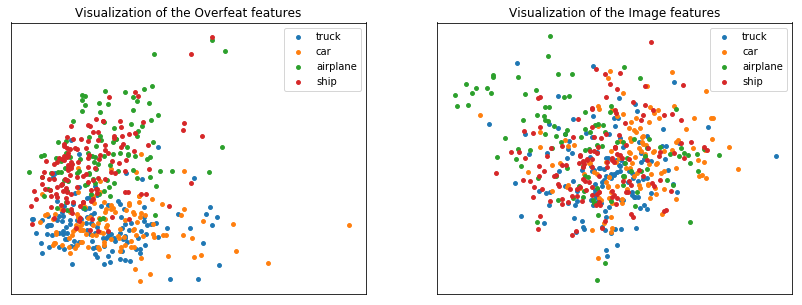

In [7]:
pca2 = PCA(n_components = 2)
O_2d = pca.transform(O_resc[:500])[:, 0:2]
X_resc = scaler.fit_transform(X)
pca2.fit(X_resc)
X_2d = pca2.transform(X_resc[:500])

fig, ax = plt.subplots(1, 2, figsize = (14, 5))
for kind in [0, 1, 2, 3]:
    idx = (y[:500] == kind)
    ax[0].scatter( O_2d[idx, 0], O_2d[idx, 1], label = '{}'.format(names[kind]), s = 15)
    ax[1].scatter(X_2d[idx, 0], X_2d[idx, 1], label = '{}'.format(names[kind]), s = 15)
ax[0].set_title('Visualization of the Overfeat features')
ax[1].set_title('Visualization of the Image features')
ax[0].legend(), ax[1].legend()
ax[0].get_xaxis().set_visible(False), ax[0].get_yaxis().set_visible(False)  
ax[1].get_xaxis().set_visible(False), ax[1].get_yaxis().set_visible(False)  
plt.show()

We see that the Overfeat features seem to be able to distinguish between the terrestrial and non-terrestrial vehicules. However, it seems to have trouble to distinguish between cars and trucks as well as between planes and ships. We suppose that one reason could be the background colour, that is generally blue for planes and ships and other colours for the terrestrial vehicules. Another reason could be the shape of the object that is long and thin for planes and ships, whereas cars and trucks have generally a more rectangular shape. 

However, if we just look at the images without image processing, the comportment is chaotic and it seems not being able to distinguish between the types, even though for example the cars are mainly located on the right hand side of the plot.

# $k$-nearest neighbors classifier


In [3]:
X_tr, X_te, y_tr, y_te, O_tr, O_te = train_test_split(X, y, O, test_size = 1000, random_state = 0, stratify = y)
X_tn, X_va, y_tn, y_va, O_tn, O_va = train_test_split(X_tr, y_tr, O_tr, test_size = 800, random_state = 0, stratify = y_tr)

In [13]:
pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components = 176, random_state = 0)),
                 ('knn', KNeighborsClassifier())])
grid = ParameterGrid({'knn__n_neighbors': [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40], 'knn__p': [1, 2]})
validation_scores = []

for i, params_dict in enumerate(grid, 1):
    pipe.set_params(**params_dict)
    pipe.fit(O_tn, y_tn)
    params_dict['accuracy'] = pipe.score(O_va, y_va)
    validation_scores.append(params_dict)

scores_df = pd.DataFrame(validation_scores)
scores_df.sort_values(by = 'accuracy', ascending = False).head()

,accuracy,knn__n_neighbors,knn__p
9,0.77750,34,2
17,0.77625,38,2
11,0.77375,35,2
7,0.77375,33,2
13,0.77250,36,2


We see after a grid search that there are multiple values with an accuracy of 77%. From now on, we will work with $k = 34$. We see that $p = 2$ gives generally better results than $p = 1$. The choice between uniform and distance weight does not have a big influence on our features. Therefore, we choose the uniform weight, because it seems more natural. For our best model, the accuracy is the same for both weights anyway. We also tested with or without scaler and we arrive at very similar accuracies. We decided to keep the scaler, because we do also a PCA step in our pipeline and PCA works better with rescaled data.

In [5]:
pipe_knn =  Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components = 176, random_state = 0)),
                      ('knn', KNeighborsClassifier(n_neighbors = 34))])
pipe_knn.fit(O_tr, y_tr)
knn_accuracy = pipe_knn.score(O_te, y_te)
print('Accuracy of the k-nearest neighbors classifier on the test set: ', knn_accuracy)

Accuracy of the k-nearest neighbors classifier on the test set:  0.776


It is a bit surprising that the accuracy is worse than before, even though we use more train points. The reason is that our parameters are optimal in respect to our train set of 3200 images and our validation set of 800 images. Using the train set of all the 4000 images and another test set may have other optimal parameters. Indeed, a grid search shows that if we used that set to train our models, the value of $k = 34$ would not be optimal. However, that implies that the test set has been used in some way to train our models and we should not do that.

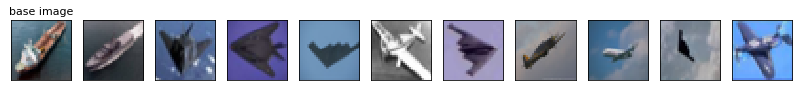

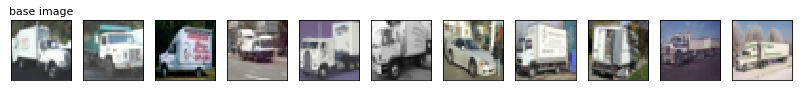

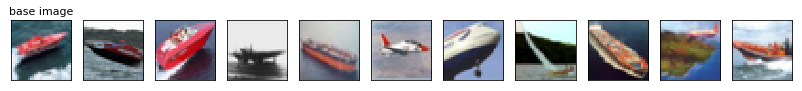

In [18]:
def closest_images(i):
    base_image = X_te[i]
    pcabi = pipe_knn.named_steps['pca'].transform(pipe_knn.named_steps['scaler'].transform(O_te[i].reshape(1, -1)))
    nearest_neighbors = pipe_knn.named_steps['knn'].kneighbors(pcabi, return_distance = False, n_neighbors = 10).flatten()
    
    fig, ax = plt.subplots(1, 11, figsize = (14, 2))
    ax[0].imshow(base_image.reshape(32, 32, 3) / 255)
    ax[0].get_yaxis().set_visible(False)
    ax[0].get_xaxis().set_visible(False)
    ax[0].set_title('base image', fontsize = 11)
    for i in range(len(nearest_neighbors)):
        img = X_tr[nearest_neighbors[i]].reshape(32, 32, 3)
        ax[i+1].imshow(img / 255)
        ax[i+1].get_xaxis().set_visible(False) 
        ax[i+1].get_yaxis().set_visible(False)  
    plt.show()

closest_images(0)
closest_images(5)
closest_images(10)

We created a function that takes an image in the test set and shows the 10 most similar images according to the $k$-nearest neighbor classifier. We are satisfied with the results. It seems that the Overfeat features are able to take in account not only the colours of the vehicules and its background, but also some topological properties, like the shape of the vehicule and its position in the image.

# Decision Trees and Random Forests

In [5]:
pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components = 176, random_state = 0)),
                 ('dtc', DecisionTreeClassifier(random_state = 0))])
grid = ParameterGrid({'dtc__max_depth' : range(1, 11)})
validation_scores = []
train_scores = []

for i, params_dict in enumerate(grid, 1):
    pipe.set_params(**params_dict)
    pipe.fit(O_tn, y_tn)
    params_dict['accuracy'] = pipe.score(O_va, y_va)
    validation_scores.append(params_dict)
    train_scores.append(pipe.score(O_tn, y_tn))

scores_df = pd.DataFrame(validation_scores)
scores_df.sort_values(by = 'accuracy', ascending = False).head()

,accuracy,dtc__max_depth
4,0.67375,5
5,0.65500,6
3,0.65250,4
6,0.65250,7
7,0.63875,8


A grid search shows us that a depth of 5 gives the best accuracy on the validation set. We compared the Gini Impurity and Cross-Entropy and the Gini Impurity gave us better results. We also used a PCA preprosessing step in order to have better results. Note that the model clearly overfits when we augment the depth, as the following graph shows.

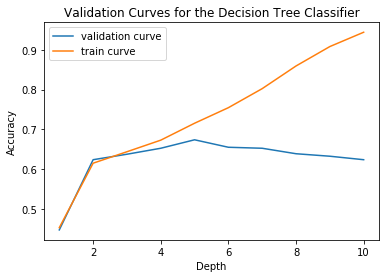

In [6]:
plt.plot(range(1, 11), scores_df['accuracy'], label = 'validation curve')
plt.plot(range(1, 11), train_scores, label = 'train curve')
plt.xlabel('Depth'), plt.ylabel('Accuracy')
plt.title('Validation Curves for the Decision Tree Classifier')
plt.legend()
plt.show()

We do now similar for the Random Forest Classifier.

In [11]:
pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components = 176, random_state = 0)),
                 ('rfc', RandomForestClassifier(random_state = 0))]) 
grid = ParameterGrid({'rfc__n_estimators' : [1, 50, 100, 150, 200, 250, 300, 332, 350, 400, 450, 500, 550, 600]})
validation_scores = []

for i, params_dict in enumerate(grid, 1):
    pipe.set_params(**params_dict)
    pipe.fit(O_tn, y_tn)
    params_dict['accuracy'] = pipe.score(O_va, y_va)
    validation_scores.append(params_dict)

scores_df = pd.DataFrame(validation_scores)
scores_df.sort_values(by = 'accuracy', ascending = False).head()

,accuracy,rfc__n_estimators
7,0.78625,332
6,0.78500,300
5,0.78250,250
4,0.78000,200
8,0.78000,350


We did again a grid search in order to optimise the parameters. We arrived at the conclusion (after a refined grid search) that a good number of estimators is 332. We also tried to tune the maximal depth, but generally it gives worse results than without maximal depth, which we used here.

We now want to see what is the accuracy of these two models on the test set.

In [6]:
pipe_dtc = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components = 176, random_state = 0)),
                 ('dtc', DecisionTreeClassifier(max_depth = 5, random_state = 0))])
pipe_rfc = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components = 176, random_state = 0)),
                 ('rfc', RandomForestClassifier(n_estimators = 332, random_state = 0))]) 

pipe_dtc.fit(O_tr, y_tr)
dtc_accuracy = pipe_dtc.score(O_te, y_te)
pipe_rfc.fit(O_tr, y_tr)
rfc_accuracy = pipe_rfc.score(O_te, y_te)

print('Accuracy of the Decision Tree Classifier on the test set: ', dtc_accuracy)
print('Accuracy of the Random Forest Classifier on the test set: ', rfc_accuracy)

Accuracy of the Decision Tree Classifier on the test set:  0.657
Accuracy of the Random Forest Classifier on the test set:  0.78


Here again, we have a slightly smaller accuracy than on our validation set. It is probably again due to the parameters that are not optimzed for that test set. However, like for the $k$-nearest neigbors classifier, they are very similar and it is a good sign.

We also note that the Random Forest Classifier gives better results than the Decision Tree Classifier, that is logical because in some way, since this algorithm is a generalization of the other.

# Support Vector Machines

In [9]:
pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components = 176, random_state = 0)),
                 ('linsvm', LinearSVC(random_state = 0))]) 
gridcv = GridSearchCV(pipe, {'linsvm__C' : [0.001, 0.004, 0.01, 0.05, 0.1, 0.5, 1]}, cv = 5)
gridcv.fit(O_tr, y_tr)
scores_df =  pd.DataFrame.from_items([('C', gridcv.cv_results_['param_linsvm__C']),
                                      ('mean_te', gridcv.cv_results_['mean_test_score']),
                                      ('std_te', gridcv.cv_results_['std_test_score'])])
scores_df.sort_values(by = 'mean_te', ascending = False).head()

,C,mean_te,std_te
1,0.004,0.83275,0.014305
0,0.001,0.83250,0.014470
3,0.05,0.83100,0.014129
2,0.01,0.83050,0.014590
4,0.1,0.82750,0.015752


In order to tune the Linear Support Vector Classifier, we made a grid search with cross-validation and our best value is $C = 0.004$. We used a stratified $5$-fold strategy (the method stratifies by default, that is important) and chose the LinearSV Classifier, instead of SVC because it optimises the already long computation times. 

In [10]:
pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components = 176, random_state = 0)),
                 ('rbfsvm', SVC(kernel = 'rbf', random_state = 0))]) 
gridcv = GridSearchCV(pipe, {'rbfsvm__C' : [1, 1.2, 1.5], 'rbfsvm__gamma' : [ 0.0001, 0.0002, 0.0005]}, cv = 5)
gridcv.fit(O_tr, y_tr)
scores_df =  pd.DataFrame.from_items([('C', gridcv.cv_results_['param_rbfsvm__C']),
                                      ('gamma', gridcv.cv_results_['param_rbfsvm__gamma']),
                                      ('mean_te', gridcv.cv_results_['mean_test_score']),
                                      ('std_te', gridcv.cv_results_['std_test_score'])])
scores_df.sort_values(by = 'mean_te', ascending = False).head()

,C,gamma,mean_te,std_te
4,1.2,0.0002,0.83850,0.011974
7,1.5,0.0002,0.83800,0.011281
1,1,0.0002,0.83625,0.009811
6,1.5,0.0001,0.83350,0.010259
8,1.5,0.0005,0.83225,0.010765


We used the same method for the Radial Basis Function Kernel and the grid-search with cross-validation gives us good values with $\gamma = 0.0002$ and $C = 1.2$. We test now these models on the test set :

In [7]:
pipe_lin = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components = 176, random_state = 0)),
                     ('linsvm', LinearSVC(C = 0.004, random_state = 0))]) 
pipe_rbf = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components = 176, random_state = 0)),
                     ('rbfsvm', SVC(C = 1.2, gamma = 0.0002, random_state = 0))]) 

pipe_lin.fit(O_tr, y_tr)
lin_accuracy = pipe_lin.score(O_te, y_te)
pipe_rbf.fit(O_tr, y_tr)
rbf_accuracy = pipe_rbf.score(O_te, y_te)

print('Accuracy of the Linear SVM Classifier on the test set: ', lin_accuracy)
print('Accuracy of the SVM Classifier with RBF Kernel on the test set: ', rbf_accuracy)

Accuracy of the Linear SVM Classifier on the test set:  0.813
Accuracy of the SVM Classifier with RBF Kernel on the test set:  0.831


Both SVM Classifiers give very satisfying results on the test set. The downside of these methods is that they are computationally expensive, that is not ideal when doing a grid search in order to tune the hyperparameters.

# Logistic Regression

In [6]:
pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(random_state = 0)),
                 ('logreg', SGDClassifier(loss = 'log', max_iter = 1000, tol = 1e-3, random_state = 0))]) 
gridcv = GridSearchCV(pipe, {'pca__n_components' : [ 1000, None, 176], 'logreg__alpha' : [ 0.2, 0.01, 0.004, 0.05]}, cv = 5)
gridcv.fit(O_tr, y_tr)
scores_df =  pd.DataFrame.from_items([('n_components', gridcv.cv_results_['param_pca__n_components']),
                                      ('alpha', gridcv.cv_results_['param_logreg__alpha']),
                                      ('mean_te', gridcv.cv_results_['mean_test_score']),
                                      ('std_te', gridcv.cv_results_['std_test_score'])])
scores_df.sort_values(by = 'mean_te', ascending = False).head()

,n_components,alpha,mean_te,std_te
6,1000,0.004,0.83900,0.011023
7,None,0.004,0.83725,0.017471
3,1000,0.01,0.83575,0.011000
1,None,0.2,0.83425,0.016058
4,None,0.01,0.83225,0.012831


We need to keep more components than 176 in order to have the best accuracy. 1000 components give good results with $\alpha = 0.004$. So, it seems that this is the best possible estimator.

However, we decide to use $\alpha = 0.2$, because it gives better results for assigning probability values, as we do after. Using $\alpha = 0.004$ (and similarily for $\alpha = 0.01$) assigns a probability of one for the most plausible result, even if it is wrong. Using $\alpha = 0.2$ gives us a better understanding when the algorithm is hesitating between different vehiclues. We will give more details later.

In [8]:
pipe_log = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components = None, random_state = 0)),
                     ('logreg', SGDClassifier(loss = 'log', max_iter = 1000, tol = 1e-3, alpha = 0.2, random_state = 0))]) 
pipe_log2 = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components = 1000, random_state = 0)),
                     ('logreg', SGDClassifier(loss = 'log', max_iter = 1000, tol = 1e-3, alpha = 0.004, random_state = 0))])
pipe_log.fit(O_tr, y_tr)
pipe_log2.fit(O_tr, y_tr)
log_accuracy = pipe_log.score(O_te, y_te)
print('Accuracy of the Logistic Regression Classifier on the test set: ', log_accuracy)

Accuracy of the Logistic Regression Classifier on the test set:  0.826


Our classifier with $\alpha = 0.2$ and no PCA pre-processing step gives an accuracy of 82.6 % on the test set. In fact, both classifiers give the same accuracy on the test set. We illustrate now the big difference between the classifiers.

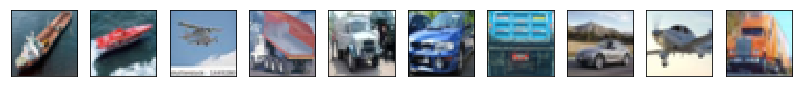

In [8]:
def visualise_images(X, labels):
    fig, ax = plt.subplots(1, 10, figsize = (14, 2))
    for i in range(len(labels)):
        img = X[labels[i]].reshape(32, 32, 3)
        ax[i].imshow(img / 255)
        ax[i].get_xaxis().set_visible(False) 
        ax[i].get_yaxis().set_visible(False)  
    plt.show()
images = [0, 10, 15, 17, 20, 25, 30, 35, 40, 45]   
visualise_images(X_te, images)

In [9]:
probas = []
scores_df = pd.DataFrame(columns = names)
for i in range(10):
    pcai = pipe_log.named_steps['pca'].transform(pipe_log.named_steps['scaler'].transform(O_te[images[i]].reshape(1, -1)))
    scores_df.loc[i] = ['%.3f' % pipe_log.named_steps['logreg'].predict_proba(pcai)[0][i] for i in range(4)] 
scores_df.index += 1 
scores_df

,truck,car,airplane,ship
1,0.000,0.000,0.627,0.373
2,0.000,0.000,0.005,0.995
3,0.000,0.000,0.975,0.025
4,0.113,0.194,0.367,0.325
5,0.920,0.078,0.000,0.001
6,0.002,0.976,0.000,0.022
7,0.333,0.511,0.014,0.142
8,0.068,0.932,0.000,0.000
9,0.003,0.000,0.985,0.011
10,0.229,0.002,0.001,0.768


The algorithm assigns a probabilty to what type of image it is. Sometimes, it assesses the image incorrectly like for image 1, 4, 7 or 10, but we see that it hesitates with the correct answer.

In [10]:
probas = []
scores_df = pd.DataFrame(columns = names)
for i in range(10):
    pcai = pipe_log2.named_steps['pca'].transform(pipe_log2.named_steps['scaler'].transform(O_te[images[i]].reshape(1, -1)))
    scores_df.loc[i] = ['%.3f' % pipe_log2.named_steps['logreg'].predict_proba(pcai)[0][i] for i in range(4)] 
scores_df.index += 1
scores_df

,truck,car,airplane,ship
1,0.000,0.000,0.526,0.474
2,0.000,0.000,0.000,1.000
3,0.000,0.000,1.000,0.000
4,0.000,1.000,0.000,0.000
5,1.000,0.000,0.000,0.000
6,0.000,1.000,0.000,0.000
7,1.000,0.000,0.000,0.000
8,0.000,1.000,0.000,0.000
9,0.000,0.000,1.000,0.000
10,0.855,0.000,0.000,0.145


With $\alpha = 0.004$, the algorithm is sure of its answer for most pictures. Somehow, it was able to convince itself that images 7 and 10 are indeed trucks. The problem is that sometimes it assigns with absolute certainety an image, even if it is wrong, like image 4. This is the reason why we prefer the first algorithm (with $\alpha = 0.2$), even though the accuracy on the train set is slightly worse.

# Multilayer Fully Connected Network

In [16]:
graph = tf.Graph()

with graph.as_default():
    O = tf.placeholder(dtype = tf.float32, shape = [None, 4096])
    y = tf.placeholder(dtype = tf.int32, shape = [None])
   
    hidden = tf.layers.dense(O, 64, activation = tf.nn.relu, 
                             kernel_initializer = tf.variance_scaling_initializer(scale = 2, seed = 0),
                             bias_initializer = tf.zeros_initializer(), name = 'hidden')
    
    training = tf.placeholder(dtype = tf.bool)
    hidden = tf.layers.dropout(hidden, rate = 0.5, seed = 0, training = training)
    
    logits = tf.layers.dense(hidden, 4, activation = None, 
                             kernel_initializer = tf.variance_scaling_initializer(scale = 1, seed = 0),
                             bias_initializer = tf.zeros_initializer(), name = 'output')
    
    with tf.variable_scope('hidden', reuse = True):
        W_1 = tf.get_variable('kernel')
    with tf.variable_scope('output', reuse = True):
        W_2 = tf.get_variable('kernel')
    
    alpha = tf.placeholder(dtype = tf.float32)
    mean_ce = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y, logits = logits))
    loss = mean_ce + alpha * (tf.nn.l2_loss(W_1)+ tf.nn.l2_loss(W_2))
    
    lr = tf.placeholder(dtype = tf.float32)
    gd = tf.train.GradientDescentOptimizer(learning_rate = lr)
    train_op = gd.minimize(loss)
    
    predictions = tf.argmax(logits, axis = 1, output_type = tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype = tf.float32))

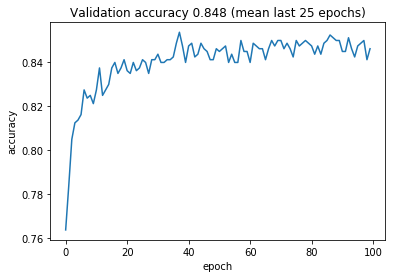

In [19]:
valid_acc_values = []
scaler = StandardScaler()
O_train = scaler.fit_transform(O_tn)
O_valid = scaler.transform(O_va)

def get_batches(X, y, batch_size):
    shuffled_idx = np.arange(len(y)) 
    np.random.shuffle(shuffled_idx)
    for i in range(0, len(y), batch_size):
        batch_idx = shuffled_idx[i: i + batch_size]
        yield X[batch_idx], y[batch_idx]

with tf.Session(graph = graph) as sess:
    sess.run(tf.global_variables_initializer())
    np.random.seed(0)
    for epoch in range(100):
        batch_acc = []
        for O_batch, y_batch in get_batches(O_train, y_tn, 64):
            acc_value = sess.run([train_op, accuracy], feed_dict = {O: O_batch, y: y_batch, alpha: 0.1, 
                                                                    lr: 0.007, training: True})
            batch_acc.append(acc_value[1])
        valid_acc = sess.run(accuracy, feed_dict = {O: O_valid, y: y_va, training: False})
        valid_acc_values.append(valid_acc)

plt.plot(valid_acc_values)
plt.title('Validation accuracy {:.3f} (mean last 25 epochs)'.format(np.mean(valid_acc_values[-25:])))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In our model, we used 100 epochs, $\alpha = 0.1$ and a learning rate of 0.007, after optimizing the parameters. Using more epochs give a slightly better accuracy, as one may expect. However, it becomes significantly more expensive computationally for very little gains. We decided to keep 100 epochs, because it is a good compromise between the accuracy of the model and the computation times. Modifying the learning rate influences the amplitude of the curve, if it is very small, the graph is similar to the one of a logarithmic function; if it is large, it becomes similar to a sine function. The $\alpha$ parameter has probably the most significant influence on the validation accuracy.

In [18]:
scaler = StandardScaler()
O_tra = scaler.fit_transform(O_tr)
O_test = scaler.transform(O_te)

with tf.Session(graph = graph) as sess:
    sess.run(tf.global_variables_initializer())
    np.random.seed(0)
    for epoch in range(100):
        batch_acc = []
        for O_batch, y_batch in get_batches(O_tra, y_tr, 64):
            acc_value = sess.run([train_op, accuracy], feed_dict = {O: O_batch, y: y_batch, alpha: 0.1, 
                                                                    lr: 0.007, training: True})
            batch_acc.append(acc_value[1])
    accuracy_mfc = sess.run(accuracy, feed_dict = {O: O_test, y: y_te, training: False})

print('Accuracy of the multilayer fully-connected network on the test set: {:.3f}'.format(accuracy_mfc))

Accuracy of the multilayer fully-connected network on the test set: 0.840


We obtain using a high accuracy on the test set, after training the model with the whole train set.

# Convolutional Neural Network

In [24]:
X_cent = (X - 128) / 255
X_cent = X_cent.reshape(-1, 32, 32, 3)
X_ctr, X_cte, y_tr, y_te = train_test_split(X_cent, y, test_size = 1000, random_state = 0, stratify = y)
X_ctn, X_cva, y_tn, y_va = train_test_split(X_ctr, y_tr, test_size = 800, random_state = 0, stratify = y_tr)

We centralized the data around 0 to improve the learning progress.

In [25]:
graph = tf.Graph()

with graph.as_default():
    X = tf.placeholder(dtype = tf.float32, shape = [None, 32, 32, 3])
    y = tf.placeholder(dtype = tf.int32, shape = [None])
    training = tf.placeholder(dtype = tf.bool)
    
    conv1 = tf.layers.conv2d(X, 64, (5, 5), (2, 2), 'SAME', activation = tf.nn.relu, 
                             kernel_initializer = tf.truncated_normal_initializer(stddev = 0.01, seed = 0), name = 'conv1')
    
    pool1 = tf.layers.max_pooling2d(conv1, (2, 2), (2, 2), 'SAME')
    
    conv2 = tf.layers.conv2d(pool1, 64, (3, 3), (1, 1), 'SAME', activation = tf.nn.relu, 
                             kernel_initializer = tf.truncated_normal_initializer(stddev = 0.01, seed = 0), name = 'conv2')
    
    pool2 = tf.layers.max_pooling2d(conv2, (2, 2), (2, 2), 'SAME')
    
    flat_output = tf.contrib.layers.flatten(pool2)
    flat_output = tf.layers.dropout(flat_output, rate = 0.5, seed = 0, training = training)
    
    fc1 = tf.layers.dense(flat_output, 256, activation = tf.nn.relu, 
                          kernel_initializer = tf.variance_scaling_initializer(scale = 2, seed = 0),
                          bias_initializer = tf.zeros_initializer())
    
    logits = tf.layers.dense(fc1, 4, activation = None, 
                             kernel_initializer = tf.variance_scaling_initializer(scale = 1, seed = 0),
                             bias_initializer = tf.zeros_initializer())
    
    with tf.variable_scope('conv1', reuse = True):
        conv_kernels = tf.get_variable('kernel')
        
    mean_ce = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y, logits = logits))
    lr = tf.placeholder(dtype = tf.float32)
    gd = tf.train.AdamOptimizer(learning_rate = lr)
    train_op = gd.minimize(mean_ce)
    predictions = tf.argmax(logits, axis = 1, output_type = tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype = tf.float32))

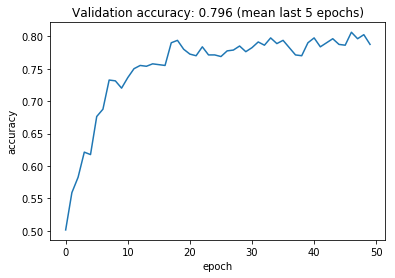

In [26]:
valid_acc_values = []
        
with tf.Session(graph = graph) as sess:
    sess.run(tf.global_variables_initializer())
    np.random.seed(0)
    for epoch in range(50):
        batch_acc = []
        for X_batch, y_batch in get_batches(X_ctn, y_tn, 64):
            acc_value = sess.run([train_op, accuracy], feed_dict = {X: X_batch, y: y_batch, lr: 0.001, training: True})
            batch_acc.append(acc_value[1])   
        valid_acc = sess.run(accuracy, feed_dict = {X: X_cva, y: y_va, training: False})
        valid_acc_values.append(valid_acc)
    
plt.plot(valid_acc_values)
plt.title('Validation accuracy: {:.3f} (mean last 5 epochs)'.format(np.mean(valid_acc_values[-5:])))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

We used a convolutional neural network similar to the one of the exercices. We used 64 filters, a first convolutional layer with $5 \times 5$ kernels and $2 \times 2$ strides, followed by a maypool layer with a $2\times 2$ pool size and $2 \times 2$ strides. Then, we used another convolutional layer with $3\times 3$ kernels and $2\times 2$ strides, followed by the same maxpool layer than above. Then we made a dropout with a 0.5 rate. We used 50 epochs, because it seems to be a good compromise between computation time and accuracy on the validation set.

In [28]:
with tf.Session(graph = graph) as sess:
    sess.run(tf.global_variables_initializer())
    np.random.seed(0)
    for epoch in range(50):
        batch_acc = []
        for X_batch, y_batch in get_batches(X_ctr, y_tr, 64):
            acc_value = sess.run([train_op, accuracy], feed_dict = {X: X_batch, y: y_batch, lr: 0.001, training: True})
            batch_acc.append(acc_value[1])   
    kernels = conv_kernels.eval()
    accuracy_cnn = sess.run(accuracy, feed_dict = {X: X_cte, y: y_te, training: False})

print('Accuracy of the convolutional neural network (of the pixel features) on the test set: {:.3f}'.format(accuracy_cnn))

Accuracy of the convolutional neural network (of the pixel features) on the test set: 0.801


We see here a surprising high accuracy, considering we used the original images and not the Overfeat features. This shows the power of the deep learning approach.

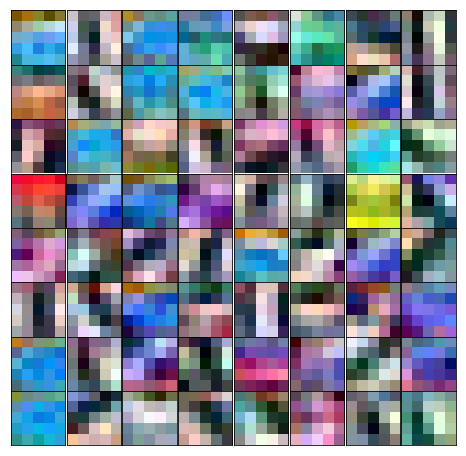

In [29]:
fig, axes = plt.subplots(8, 8, figsize = (8, 8))
plt.subplots_adjust(wspace = 0, hspace = 0)

for i, axis in enumerate(axes.flatten()):
    kernel = kernels[:, :, :, i].copy()
    kernel -= kernel.min() 
    kernel /= kernel.max() 
    axis.imshow(kernel)
    axis.get_xaxis().set_visible(False) 
    axis.get_yaxis().set_visible(False) 

plt.show()

We can take a look at the 64 kernels trained by the neural network. Of course, these are not really meaningful to us, but are able to distinguish between the different image types quite well.

# Results

In [33]:
results = pd.DataFrame({'Classifier': ['k-nearest Neighbors classifier', 'Descision Tree Classifier', 
                                       'Random Forest Classifier', 'Linear SVC', 'RBF SVC', 'Logistic Regression', 
                                       'Multilayer Fully Connected Network', 'Convolutional Neural Network'], 
                       'Accuracy on the test set': [knn_accuracy, dtc_accuracy, rfc_accuracy, lin_accuracy, rbf_accuracy,
                                                   log_accuracy, accuracy_mfc, accuracy_cnn]})
results.set_index('Classifier', inplace = True)
results

,Accuracy on the test set
Classifier,
k-nearest Neighbors classifier,0.776
Descision Tree Classifier,0.657
Random Forest Classifier,0.780
Linear SVC,0.813
RBF SVC,0.831
Logistic Regression,0.826
Multilayer Fully Connected Network,0.840
Convolutional Neural Network,0.801


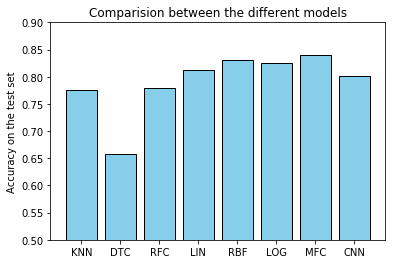

In [34]:
plt.bar(np.arange(8), results['Accuracy on the test set'], edgecolor = 'black', color = 'skyblue')
plt.xticks(np.arange(8), ['KNN', 'DTC', 'RFC', 'LIN', 'RBF', 'LOG', 'MFC', 'CNN'])
plt.ylim(0.5, 0.9)
plt.ylabel('Accuracy on the test set')
plt.title('Comparision between the different models')
plt.show()

We use this bar plot to compare the different models. We see that many classifiers have similar results on the test set. In paricular, the Support Vector Machine with RBF kernel, the Logistic Regression and the Multilayer Fully Connected Network give all very satisfying results. Note also the power of the Convolution Neural Network, that is able to give a strong accuracy using only the matrix of pixels. We decide to use the MFC approach with the Overfeat features for predicting the results, because it gives the strongest accuracy and it is not tedious to optimise its parameters.

# Predictions

As said before, we use the Multilayer Fully Connected Network approach to make predictions. We make a new model, trained on all 5000 images and using again the Overfeat features.

In [35]:
with np.load('cifar4-test.npz', allow_pickle = False) as data :
    X_test = data['pixels'].astype(np.float32)
    O_test = data['overfeat']

In [36]:
scaler = StandardScaler()
O_resc = scaler.fit_transform(O)
O_test_resc = scaler.transform(O_test)
y_train = y

In [37]:
graph = tf.Graph()

with graph.as_default():
    O = tf.placeholder(dtype = tf.float32, shape = [None, 4096])
    y = tf.placeholder(dtype = tf.int32, shape = [None])
   
    hidden = tf.layers.dense(O, 64, activation = tf.nn.relu, 
                             kernel_initializer = tf.variance_scaling_initializer(scale = 2, seed = 0),
                             bias_initializer = tf.zeros_initializer(), name = 'hidden')
    
    training = tf.placeholder(dtype = tf.bool)
    hidden = tf.layers.dropout(hidden, rate = 0.5, seed = 0, training = training)
   
    logits = tf.layers.dense(hidden, 4, activation = None, 
                             kernel_initializer = tf.variance_scaling_initializer(scale = 1, seed = 0),
                             bias_initializer = tf.zeros_initializer(), name = 'output')
    
    with tf.variable_scope('hidden', reuse = True):
        W_1 = tf.get_variable('kernel')
    with tf.variable_scope('output', reuse = True):
        W_2 = tf.get_variable('kernel')
    
    alpha = tf.placeholder(dtype = tf.float32)
    mean_ce = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y, logits = logits))
    loss = mean_ce + alpha * (tf.nn.l2_loss(W_1) + tf.nn.l2_loss(W_2))
    
    lr = tf.placeholder(dtype = tf.float32)
    gd = tf.train.GradientDescentOptimizer(learning_rate = lr)
    train_op = gd.minimize(loss)
    
    predictions = tf.argmax(logits, axis = 1, output_type = tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype = tf.float32))

In [38]:
with tf.Session(graph = graph) as sess:
    sess.run(tf.global_variables_initializer())
    np.random.seed(0)
    for epoch in range(100):
        batch_acc = []
        for O_batch, y_batch in get_batches(O_resc, y_train, 64):
            acc_value = sess.run([train_op, accuracy], feed_dict = {O: O_batch, y: y_batch, alpha: 0.1, lr: 0.002,
                                                                   training: True})
            batch_acc.append(acc_value[1])
    pred = sess.run(predictions, feed_dict = {O: O_test_resc, training : False})   

np.save('test_predictions.npy', pred)

We reoptimized the parameters using a validation set of 1000 images. Then we trained the model using the whole train set and made predictions for the test set. Taking a look at the images (using the visualise_images function) and comparing it to the predictions gives relatively accurate results.